# Nashville Housing Data Analysis using differnt ML Algorithms (Week 4)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
import statsmodels.api as sm

In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 110)

In [3]:
df = pd.read_csv('~/Predictive_Analytics/Week4/Nashville_housing_data_2013_2016.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,Parcel ID,Land Use,Property Address,Suite/ Condo #,Property City,Sale Date,Sale Price,Legal Reference,Sold As Vacant,Multiple Parcels Involved in Sale,Owner Name,Address,City,State,Acreage,Tax District,Neighborhood,image,Land Value,Building Value,Total Value,Finished Area,Foundation Type,Year Built,Exterior Wall,Grade,Bedrooms,Full Bath,Half Bath
0,0,0,105 03 0D 008.00,RESIDENTIAL CONDO,1208 3RD AVE S,8,NASHVILLE,2013-01-24,132000,20130128-0008725,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,105 11 0 080.00,SINGLE FAMILY,1802 STEWART PL,NaN,NASHVILLE,2013-01-11,191500,20130118-0006337,No,No,"STINSON, LAURA M.",1802 STEWART PL,NASHVILLE,TN,0.17,URBAN SERVICES DISTRICT,3127.0,\114000\910001.JPG,32000.0,134400.0,168300.0,1149.00000,PT BSMT,1941.0,BRICK,C,2.0,1.0,0.0
2,2,2,118 03 0 130.00,SINGLE FAMILY,2761 ROSEDALE PL,NaN,NASHVILLE,2013-01-18,202000,20130124-0008033,No,No,"NUNES, JARED R.",2761 ROSEDALE PL,NASHVILLE,TN,0.11,CITY OF BERRY HILL,9126.0,\131000\191001.JPG,34000.0,157800.0,191800.0,2090.82495,SLAB,2000.0,BRICK/FRAME,C,3.0,2.0,1.0
3,3,3,119 01 0 479.00,SINGLE FAMILY,224 PEACHTREE ST,NaN,NASHVILLE,2013-01-18,32000,20130128-0008863,No,No,"WHITFORD, KAREN",224 PEACHTREE ST,NASHVILLE,TN,0.17,URBAN SERVICES DISTRICT,3130.0,\133000\721001.JPG,25000.0,243700.0,268700.0,2145.60001,FULL BSMT,1948.0,BRICK/FRAME,B,4.0,2.0,0.0
4,4,4,119 05 0 186.00,SINGLE FAMILY,316 LUTIE ST,NaN,NASHVILLE,2013-01-23,102000,20130131-0009929,No,No,"HENDERSON, JAMES P. & LYNN P.",316 LUTIE ST,NASHVILLE,TN,0.34,URBAN SERVICES DISTRICT,3130.0,\134000\474001.JPG,25000.0,138100.0,164800.0,1969.00000,CRAWL,1910.0,FRAME,C,2.0,1.0,0.0


In [4]:
df.shape

(56636, 31)

In [5]:
df.dtypes

Unnamed: 0                             int64
Unnamed: 0.1                           int64
Parcel ID                             object
Land Use                              object
Property Address                      object
Suite/ Condo   #                      object
Property City                         object
Sale Date                             object
Sale Price                             int64
Legal Reference                       object
Sold As Vacant                        object
Multiple Parcels Involved in Sale     object
Owner Name                            object
Address                               object
City                                  object
State                                 object
Acreage                              float64
Tax District                          object
Neighborhood                         float64
image                                 object
Land Value                           float64
Building Value                       float64
Total Valu

In [6]:
#remove unwanted columns
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [7]:
#drop columns not neccessary for modeling
columns = ['Suite/ Condo   #','Owner Name','Address','City','State','image','Neighborhood','Legal Reference',
           'Property Address','Parcel ID','Tax District']
df = df.drop(columns,axis=1)

In [8]:
df.isnull().sum()

Land Use                                 0
Property City                          159
Sale Date                                0
Sale Price                               0
Sold As Vacant                           0
Multiple Parcels Involved in Sale        0
Acreage                              30619
Land Value                           30619
Building Value                       30619
Total Value                          30619
Finished Area                        32470
Foundation Type                      32472
Year Built                           32471
Exterior Wall                        32471
Grade                                32471
Bedrooms                             32477
Full Bath                            32359
Half Bath                            32490
dtype: int64

In [9]:
#drop outliers
df = df.drop(np.where(df['Acreage'] > 100)[0])

In [10]:
#drop rows where we cannot identify any aspect of the land from the data. From the above isna() table we can see that many 
#of the columns are empty for the same rows. And if we do not have details like Acreage, land value, etc we cannot identify
#the row as an existing land
df = df.drop(df.loc[df['Acreage'].isna()].index)

In [11]:
df.isnull().sum()

Land Use                                0
Property City                           2
Sale Date                               0
Sale Price                              0
Sold As Vacant                          0
Multiple Parcels Involved in Sale       0
Acreage                                 0
Land Value                              0
Building Value                          0
Total Value                             0
Finished Area                        1850
Foundation Type                      1852
Year Built                           1851
Exterior Wall                        1851
Grade                                1851
Bedrooms                             1857
Full Bath                            1739
Half Bath                            1870
dtype: int64

We can still see a few nulls in the data and now we will handle them separately

In [12]:
#replacing the empty cities as Nashville
df['Property City'] = np.where(df['Property City'].isna(),'NASHVILLE',df['Property City'])

In [13]:
#creating a new column which will determine whether the construction on the land has completed or not based on Year Built
df['Is it built?'] = pd.Series(dtype='int64')
df['Is it built?'] = np.where(df['Year Built'].isna(),0,1)

In [14]:
#creating a new column which will determine the age of the building if built
df['how old?'] = pd.Series(dtype='int64')
from datetime import datetime
def days_since(dates_series, date_format):
    n = len(dates_series)
    result = [0] * n

    for i in range(n):
        result[i] = (datetime.today() - datetime.strptime(dates_series[i], date_format)).days
    
    return result

df['how old?'] = days_since(list(df['Sale Date']), "%Y-%m-%d")
df = df.drop(columns='Sale Date')
df['how old?'].head()

1    2998
2    2991
3    2991
4    2986
5    3005
Name: how old?, dtype: int64

In [15]:
#converting different words with same meaning as the same word
df['Land Use'] = np.where(((df['Land Use'] == 'VACANT RES LAND') | (df['Land Use'] == 'VACANT RESIDENTIAL LAND') | (df['Land Use'] == 'VACANT RESIENTIAL LAND')),
                          'VACANT RESIDENTIAL LAND',df['Land Use'])

In [16]:
#reducing the cardinality of the column "Land Use" by creating 3 different categories
residential = ['SINGLE FAMILY','VACANT RESIDENTIAL LAND','DUPLEX','ZERO LOT LINE','TRIPLEX','RESIDENTIAL COMBO/MISC','QUADPLEX','MOBILE HOME','DORMITORY/BOARDING HOUSE','APARTMENT: LOW RISE (BUILT SINCE 1960)','VACANT ZONED MULTI FAMILY']

commercial = ['SPLIT CLASS','PARKING LOT','FOREST','GREENBELT','VACANT COMMERCIAL LAND','GREENBELT/RES\r\nGRRENBELT/RES','DAY CARE CENTER','TERMINAL/DISTRIBUTION WAREHOUSE','VACANT RURAL LAND','OFFICE BLDG (ONE OR TWO STORIES)','NON-PROFIT CHARITABLE SERVICE','CONVENIENCE MARKET WITHOUT GAS','METRO OTHER THAN OFC, SCHOOL,HOSP, OR PARK','STRIP SHOPPING CENTER','CLUB/UNION HALL/LODGE','ONE STORY GENERAL RETAIL STORE','LIGHT MANUFACTURING','NIGHTCLUB/LOUNGE','MORTUARY/CEMETERY']

religious = ['CHURCH','PARSONAGE']

df['Land Use'] = np.where(df['Land Use'].isin(residential),'RESIDENTIAL',df['Land Use'])
df['Land Use'] = np.where(df['Land Use'].isin(commercial),'COMMERCIAL',df['Land Use'])
df['Land Use'] = np.where(df['Land Use'].isin(religious),'RELIGIOUS',df['Land Use'])

In [17]:
#converting objects to numerical values
df['Sold As Vacant'] = np.where(df['Sold As Vacant']=='Yes',1,0)
df['Sold As Vacant'] = df['Sold As Vacant'].astype(int)

df['Multiple Parcels Involved in Sale'] = np.where(df['Multiple Parcels Involved in Sale']=='Yes',1,0)
df['Multiple Parcels Involved in Sale'] = df['Multiple Parcels Involved in Sale'].astype(int)

In [18]:
#one hot encoding for all object datatype columns
df_model = pd.get_dummies(df, columns=['Land Use','Property City','Foundation Type','Exterior Wall','Grade'])
df_model.head()

,Sale Price,Sold As Vacant,Multiple Parcels Involved in Sale,Acreage,Land Value,Building Value,Total Value,Finished Area,Year Built,Bedrooms,Full Bath,Half Bath,Is it built?,how old?,Land Use_COMMERCIAL,Land Use_RELIGIOUS,Land Use_RESIDENTIAL,Property City_ANTIOCH,Property City_BELLEVUE,Property City_BRENTWOOD,Property City_GOODLETTSVILLE,Property City_HERMITAGE,Property City_JOELTON,Property City_MADISON,Property City_MOUNT JULIET,Property City_NASHVILLE,Property City_OLD HICKORY,Property City_WHITES CREEK,Foundation Type_CRAWL,Foundation Type_FULL BSMT,Foundation Type_PIERS,Foundation Type_PT BSMT,Foundation Type_SLAB,Foundation Type_TYPICAL,Exterior Wall_BRICK,Exterior Wall_BRICK/FRAME,Exterior Wall_CONC BLK,Exterior Wall_FRAME,Exterior Wall_FRAME/STONE,Exterior Wall_LOG,Exterior Wall_METAL,Exterior Wall_PRECAST CONC,Exterior Wall_STONE,Exterior Wall_STUCCO,Grade_A,Grade_AAB,Grade_AAC,Grade_B,Grade_C,Grade_D,Grade_E,Grade_IDC,Grade_OFB,Grade_OFC,Grade_OMB,Grade_SRC,Grade_SRD,Grade_SSC,Grade_TAC,Grade_TCB,Grade_TCC,Grade_TCD,Grade_TFC,Grade_X
1,191500,0,0,0.17,32000.0,134400.0,168300.0,1149.00000,1941.0,2.0,1.0,0.0,1,2998,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,202000,0,0,0.11,34000.0,157800.0,191800.0,2090.82495,2000.0,3.0,2.0,1.0,1,2991,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,32000,0,0,0.17,25000.0,243700.0,268700.0,2145.60001,1948.0,4.0,2.0,0.0,1,2991,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,102000,0,0,0.34,25000.0,138100.0,164800.0,1969.00000,1910.0,2.0,1.0,0.0,1,2986,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,93736,0,0,0.17,25000.0,86100.0,113300.0,1037.00000,1945.0,2.0,1.0,0.0,1,3005,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Linear Regression

In [19]:
df_linear = df_model.copy()

In [20]:
#filling the remaining null values as 0 because Linear regression cannot handle null values
df_linear = df_linear.fillna(0)

In [21]:
df_1=df_linear.drop(columns=['Sale Price'],axis=1)

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_1,
                                                    df_linear["Sale Price"],
                                                    test_size=0.30,
                                                    random_state=42)

In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

LR = LinearRegression()
LR.fit(X_train_scaled.values, y_train.values)

LinearRegression()

In [27]:
y_pred = LR.predict(X_test_scaled)

In [32]:
df_1.columns.size

63

In [34]:
LR.coef_.size

63

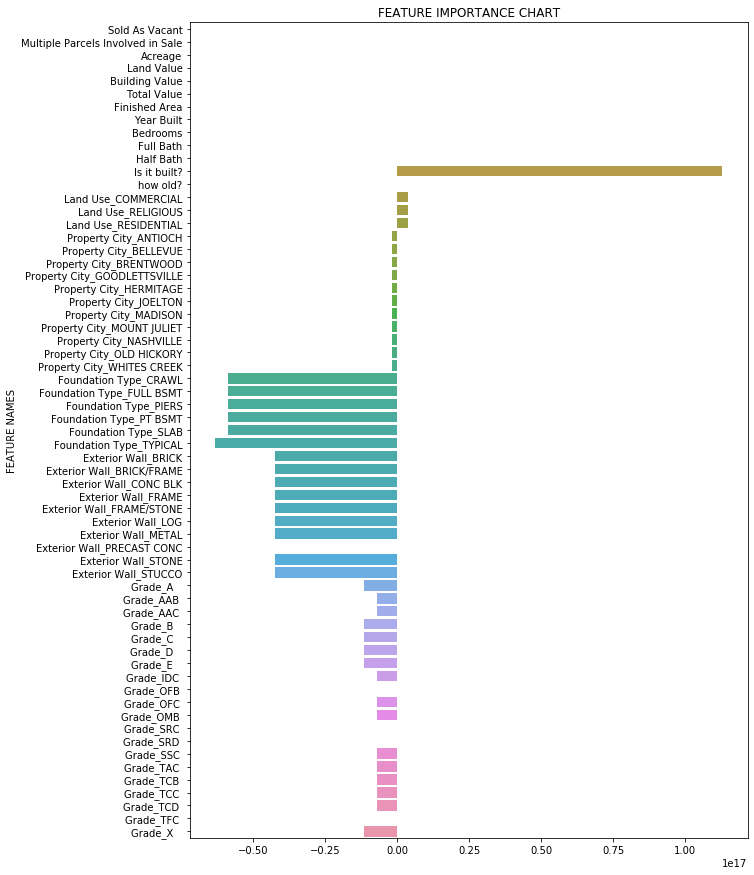

In [36]:
plt.figure(figsize=(10,15))
sns.barplot(x=LR.coef_, y=df_1.columns)
plt.title('FEATURE IMPORTANCE CHART')
plt.ylabel('FEATURE NAMES')
plt.show()

In [28]:
print('R2 score:',r2_score(y_test.values,y_pred))
print('Mean Squared Error:',mean_squared_error(y_test.values,y_pred))
print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test.values,y_pred)))
print('Mean Absolute Error:',mean_absolute_error(y_test.values,y_pred))

R2 score: -4.852798836882028e+18
Mean Squared Error: 6.996922218665343e+29
Root Mean Squared Error: 836476073696393.5
Mean Absolute Error: 16627282840734.66


Negative value of R2 score becasue the problem does not fit as a Linear problem

## Decision Trees

In [383]:
from sklearn.tree import DecisionTreeRegressor
DT = DecisionTreeRegressor(random_state=0)
DT.fit(X_train.values,y_train.values)


DecisionTreeRegressor(random_state=0)

In [384]:
y_pred_DT = DT.predict(X_test)

In [385]:
print('R2 score:',r2_score(y_test.values,y_pred_DT))
print('Mean Squared Error:',mean_squared_error(y_test.values,y_pred_DT))
print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test.values,y_pred_DT)))
print('Mean Absolute Error:',mean_absolute_error(y_test.values,y_pred_DT))

R2 score: 0.3480445297747029
Mean Squared Error: 94001046994.37158
Root Mean Squared Error: 306595.90178991563
Mean Absolute Error: 80059.33151825753


Great improvement from Linear regression

## Random Forest

In [386]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train.values,y_train.values)


RandomForestRegressor(random_state=42)

In [387]:
y_pred_rf = rf.predict(X_test)

In [388]:
print('R2 score:',r2_score(y_test.values,y_pred_rf))
print('Mean Squared Error:',mean_squared_error(y_test.values,y_pred_rf))
print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test.values,y_pred_rf)))
print('Mean Absolute Error:',mean_absolute_error(y_test.values,y_pred_rf))

R2 score: 0.6527821978881847
Mean Squared Error: 50062985010.79549
Root Mean Squared Error: 223747.59218993952
Mean Absolute Error: 62586.18186623755


Values are almost double from decision trees regressor

## XGBoost

In [389]:
#XGBoost can handle null values so feeding it with the original data
df_1_xgb=df_model.drop(columns=['Sale Price'],axis=1)

In [390]:
from sklearn.model_selection import train_test_split
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(df_1_xgb,
                                                    df_model["Sale Price"],
                                                    test_size=0.30,
                                                    random_state=42)

In [391]:
import xgboost as xgb
xgboost = xgb.XGBRegressor()
xgboost.fit(X_train_xgb, y_train_xgb)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [392]:
y_pred_xgb = xgboost.predict(X_test_xgb)

In [393]:
print('R2 score:',r2_score(y_test_xgb.values,y_pred_xgb))
print('Mean Squared Error:',mean_squared_error(y_test_xgb.values,y_pred_xgb))
print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test_xgb.values,y_pred_xgb)))
print('Mean Absolute Error:',mean_absolute_error(y_test_xgb.values,y_pred_xgb))

R2 score: 0.6678875022061043
Mean Squared Error: 47885053409.7885
Root Mean Squared Error: 218826.53726133972
Mean Absolute Error: 64039.1045329141


R2 score improved a bit. According to the calculated metrics, XGBoost is the best model as it calculated with the original data without imputing Nulls with zeroes. It does not overfit the data. It runs its own regularization technique without actually calling it. We can improve this model even further by hyperparameter tuning.